** SSVI **

$$ w(k, \theta_t) = \frac{\theta_t}{2} \left \{ 1 + \rho \varphi(\theta_t)k + \sqrt{(\varphi(\theta_t)k+\rho)^2 + (1-\rho^2)} \right \} $$

- $ \theta_t = \sigma^2(0,t)t$, 其中 $\sigma_t$ 是ATM的隐含波动率
- $\rho$ 是左右偏度
- $\varphi(\theta_t)$ 是平滑函数 

**无套利条件**：
1. $$\partial_t\theta_t \geqslant 0, for \; all \; t > 0$$
1. $$0 \leqslant \partial_\theta  (\theta\varphi(\theta)) \leqslant \frac{1}{\rho^2}\left(1+\sqrt{1-\rho^2} \right )\varphi(\theta)$$
1. $$ \theta\varphi(\theta)(1+|\rho|) < 4 , for \; all \; \theta >0$$
1. $$ \theta\varphi(\theta)^2(1+|\rho|) < 4 , for \; all \; \theta >0$$

**Example 1**:
$$ \varphi(\theta) = \frac{1}{\lambda\theta} \left \{ 1-\frac{1-e^{-\lambda\theta}}{\lambda\theta} \right \} $$

with $\lambda \geqslant (1+ |\rho|) / 4 $ 

**Example 2**:
$$ \varphi(\theta) = \frac{\eta}{\theta^\gamma(1+\theta)^{1-\gamma}} $$

with $\gamma \subset (0,1/2] $ andd $\eta(1+|\rho|) \leqslant 2 $

$$ paramater[0] = \theta $$
$$ paramater[1] = \rho $$
$$ paramater[2] = \eta $$
$$ paramater[3] = \gamma $$

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
## 一天的波动率数据
columns = np.array([-0.13003472, -0.11134259, -0.09299345, -0.07497494, -0.05727537,
       -0.03988362, -0.02278919, -0.00598207,  0.02680775,  0.05855645,
        0.08932811,  0.11918107])
index = np.array([  9.,  29.,  49., 109.])
values = np.array([[0.29067656, 0.26138457, 0.22974922, 0.19108379, 0.17760947,
        0.16677144, 0.15315066, 0.14143386, 0.13586838, 0.15944844,
        0.20162891, 0.24849609],
       [0.18346787, 0.16677144, 0.15549402, 0.14846394, 0.13887081,
        0.13433055, 0.13140135, 0.13143797, 0.13476993, 0.1398228 ,
        0.15241836, 0.16896833],
       [0.17057939, 0.16223118, 0.1537365 , 0.14758518, 0.14158032,
        0.13960311, 0.13755267, 0.13458686, 0.14926947, 0.15197898,
        0.15922875, 0.16779666],
       [0.15556725, 0.15036792, 0.14692611, 0.14359415, 0.14136063,
        0.13927358, 0.13872435, 0.13929189, 0.15728815, 0.16045535,
        0.164245  , 0.17032309]])
X = pd.DataFrame(values, columns=columns, index=index)

In [5]:
strike = X.columns.values
maturity = X.index.values.reshape((-1,1))
implied_volatility = X.values
w = implied_volatility**2 * maturity

In [6]:
from scipy.optimize import least_squares

In [7]:
def phi(A):
    """
    平滑函数： 
    $$ \varphi(\theta) = \frac{\eta}{\theta^\gamma(1+\theta)^{1-\gamma}} $$
    """
    return A[2] / (A[0]**A[3]*(1+A[0])**(1-A[3]))

def model(A, x):
    """
    SSVI 函数
    $$ w(k, \theta_t) = \frac{\theta_t}{2} \left \{ 1 + \rho \varphi(\theta_t)k + \sqrt{(\varphi(\theta_t)k+\rho)^2 + (1-\rho^2)} \right \} $$
    """
    return A[0]/2 * (1 + A[1]*phi(A)*x + ((phi(A)*x + A[1])**2 + 1 - A[1]**2)**0.5)

## 拟合

In [8]:
def fun_penalty(A, x, y,paramater_pre):
    """
    优化目标函数
    """
    least_squar = (model(A, x) - y)**2  ## 最小二乘
    penalty_eta =  1*(A[2] * (1+np.abs(A[1])) - 2)**2  ## 无蝶式套利约束条件
    c = model(A, x) - model(paramater_pre, x)   ## 无 time spread 套利
    penalty_maturity = np.sum(c[c<0]) **2
    return  least_squar + penalty_maturity  #+ penalty_eta

In [9]:
def fit_svi(strike, w):
    """
    拟合SVI，得到对应系数
    
    参数：
    strike: 1d array $ln(k/s)$ 对数行权价
    w : 2d array 总体方差， $\sigma^2*t$
    """
    paramater = np.random.rand(w.shape[0],4)
    paramater_pre = np.ones(4) / 10
    for i in range(4):
        res = least_squares(fun_penalty, paramater_pre, args=(strike, w[i], paramater_pre), 
                            bounds=((-np.inf, -np.inf, -np.inf, 0),(np.inf, np.inf, np.inf, 0.5)))
        paramater[i] = res.x
        paramater_pre = res.x
    return paramater

In [10]:
paramater = fit_svi(strike, w)

## 二维图

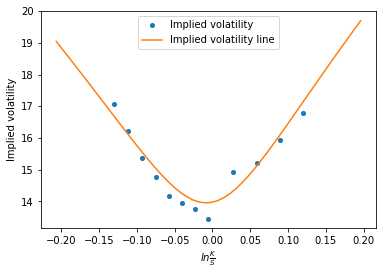

In [11]:
i = 2

import matplotlib.pyplot as plt
u_test = np.linspace(strike.min()-strike.std(), strike.max()+strike.std())
y_test = model(paramater[i], u_test)
#plt.plot(x, w[i], 'o', markersize=4, label='Total variance')
plt.plot(strike, implied_volatility[i] *100, 'o', markersize=4, label='Implied volatility')
#plt.plot(u_test, y_test, label='Total variance line')
plt.plot(u_test, y_test**0.5 / maturity[i]**0.5 *100, label='Implied volatility line')
plt.xlabel(r'$ln\frac{K}{S}$')
plt.ylabel('Implied volatility')
plt.legend()
plt.show();

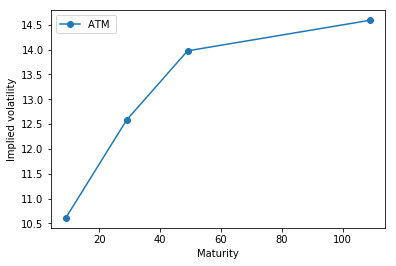

In [12]:
plt.plot(maturity, (paramater[:, 0]/maturity.reshape(-1))**0.5 *100, '-o', label='ATM ')
plt.xlabel('Maturity')
plt.ylabel('Implied volatility')
plt.legend()
plt.show();

## 三维图

In [13]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

def make_surf(X,Y,Z):
    XX,YY = np.meshgrid(np.linspace(min(X),max(X),350),np.linspace(min(Y),max(Y),350))
    ZZ = griddata(np.array([X,Y]).T,np.array(Z),(XX,YY))
    return XX,YY,ZZ

In [14]:
def plot_implied_volatility_surface(strike, maturity, paramater):
    ## frabricate data
    x_3d = np.zeros((maturity.size, strike.size))
    z_3d = np.zeros((maturity.size, strike.size))
    for i in range(4):
        x_3d[i] = strike
        z_3d[i] = model(paramater[i], strike)
    x_3d = x_3d.reshape(-1)
    y_3d = np.repeat(maturity, strike.size).reshape((4,strike.size)).reshape(-1)
    z_3d = z_3d.reshape(-1)

    fig = plt.figure(figsize=(10,6))
    ax = Axes3D(fig,  azim =-50,elev = 10)
    ax.scatter3D(x_3d, y_3d, z_3d)

    ## plot 3d implied volatility surface
    ax.plot_surface(*make_surf(x_3d, y_3d, z_3d))
    #ax.plot_wireframe(*make_surf(x_3d, y_3d, z_3d))
    plt.xlabel(r'$ln\frac{K}{S}$')
    plt.ylabel('Maturity')
    ax.set_zlabel('Implied Volatility')
    plt.show();

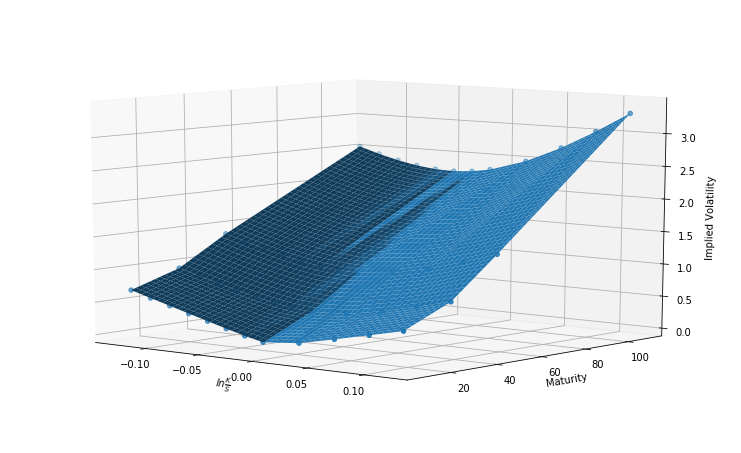

In [15]:
plot_implied_volatility_surface(strike, maturity, paramater)